In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from IPython.display import Audio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.signal import stft
import librosa
import meltysynth as ms
from ts_utils import convert_mp3_and_midi, mp3_to_ts, midi_to_wav
from display import midi_to_image

In [25]:
Audio('autre_data/pirate.wav')

In [26]:
from statsmodels.tsa.stattools import acf

ts, sr = mp3_to_ts('autre_data/pirate.wav')

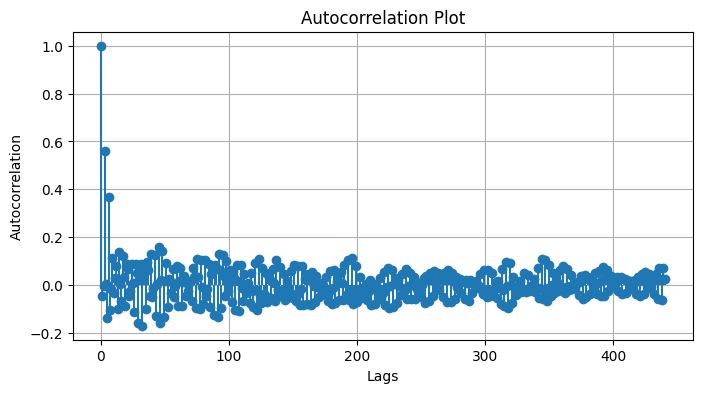

In [27]:
autocorrelations = acf(ts, nlags=sr*10)

auto = autocorrelations[list(range(0, sr*10, 1000))]

# Plot autocorrelation
plt.figure(figsize=(8, 4))
plt.stem(range(len(auto)), auto, basefmt=" ")
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.grid()
plt.show()

In [122]:
import os
import random
import numpy as np

# Assuming you have a function like this to create X, y from files:
# X, y = convert_mp3_and_midi(mp3_file, midi_file, sample_rate, duration, ...)
# Your function might return numpy arrays or torch tensors.

def load_data_from_folder(folder, sample_rate, duration, ticks_per_beat, bpm, overlap_ratio, freq_resolution):
    """
    Given a folder with audio and MIDI files, this function will load the data
    into X and y arrays, split them into train and test sets (80% train, 20% test).
    """
    
    # List all .wav and .mid files in the folder
    mp3_files = [f for f in os.listdir(folder) if f.endswith('.wav')]
    midi_files = [f for f in os.listdir(folder) if f.endswith('.mid')]
    
    # Create a list of tuples with mp3 and midi files
    file_pairs = [(mp3, midi) for mp3, midi in zip(mp3_files, midi_files)]

    # Shuffle the list of files to ensure random splitting
    random.shuffle(file_pairs)

    # Split the data into training (80%) and testing (20%) sets
    num_train = int(0.8 * len(file_pairs))
    train_files = file_pairs[:num_train]
    test_files = file_pairs[num_train:]

    # Initialize lists to store the training and testing data
    X_train, y_train = [], []
    X_test, y_test = [], []

    # Load training data
    for mp3_file, midi_file in train_files:
        mp3_path = os.path.join(folder, mp3_file)
        midi_path = os.path.join(folder, midi_file)
        
        X, y = convert_mp3_and_midi(mp3_path, midi_path, sample_rate, duration,
                                     ticks_per_beat=ticks_per_beat, bpm=bpm,
                                     overlap_ratio=overlap_ratio, freq_resolution=freq_resolution)
        # midi_to_image(midi_path, ticks_per_beat, bpm, duration, True, 0, str(midi_path).replace(".mid", "_img.png"))
        X_train.append(X)
        y_train.append(y)

    # Load testing data
    for mp3_file, midi_file in test_files:
        mp3_path = os.path.join(folder, mp3_file)
        midi_path = os.path.join(folder, midi_file)
        
        X, y = convert_mp3_and_midi(mp3_path, midi_path, sample_rate, duration,
                                     ticks_per_beat=ticks_per_beat, bpm=bpm,
                                     overlap_ratio=overlap_ratio, freq_resolution=freq_resolution)
        # midi_to_image(midi_path, ticks_per_beat, bpm, duration, True, 0, str(midi_path).replace(".mid", "_img.png"))
        X_test.append(X)
        y_test.append(y)

    # Convert lists to numpy arrays or torch tensors (depending on your needs)
    X_train = np.concatenate(X_train, axis=0)  # Assuming the outputs are numpy arrays
    y_train = np.concatenate(y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    return X_train, y_train, X_test, y_test


# Example usage:

folder_path = 'simple_piano'
sample_rate = 22050
duration = None
ticks_per_beat = 4
bpm = 120
overlap_ratio = 0.5
freq_resolution = 2

X_train, y_train, X_test, y_test = load_data_from_folder(
    folder_path, sample_rate, duration, ticks_per_beat, bpm, overlap_ratio, freq_resolution
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (5607, 88), y_train shape: (5607, 88)
X_test shape: (1089, 88), y_test shape: (1089, 88)


In [123]:
# X, y = convert_mp3_and_midi(
#     'autre_data/pirate.wav', 'autre_data/pirate.mid',
#     22050, 60, ticks_per_beat=16, bpm=120, overlap_ratio=0.5,
#     freq_resolution=2
# )

In [124]:
# from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split

# # Split data into training and testing sets
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

mean, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


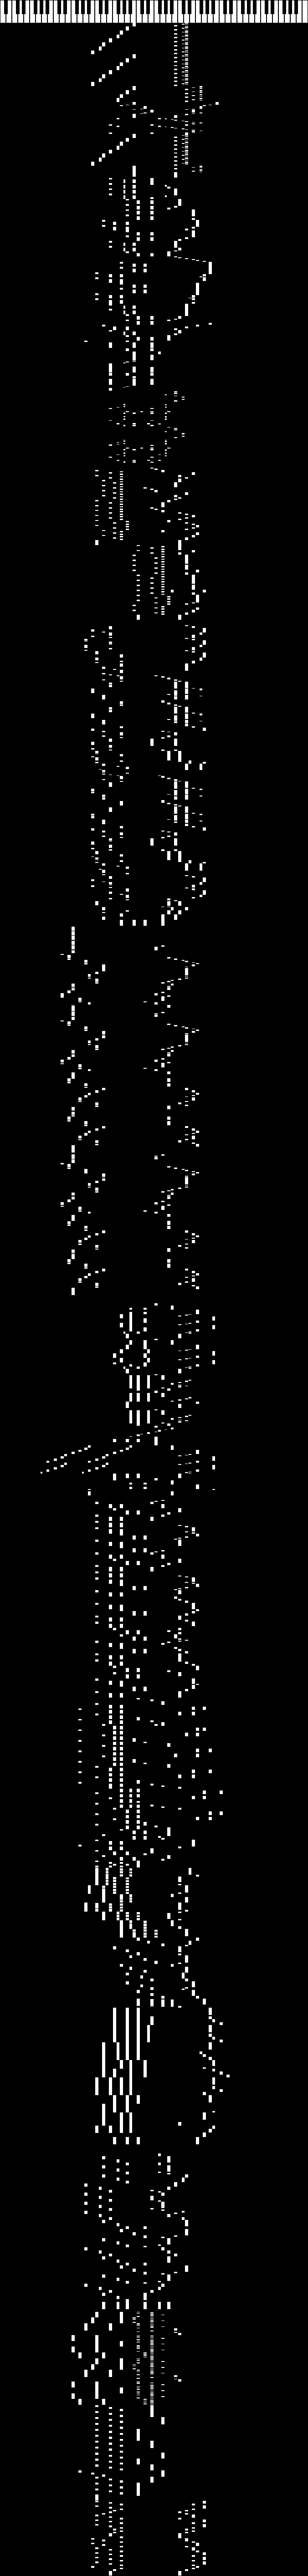

In [125]:
midi_to_image(y_train, ticks_per_beat, bpm, None, True, 0)

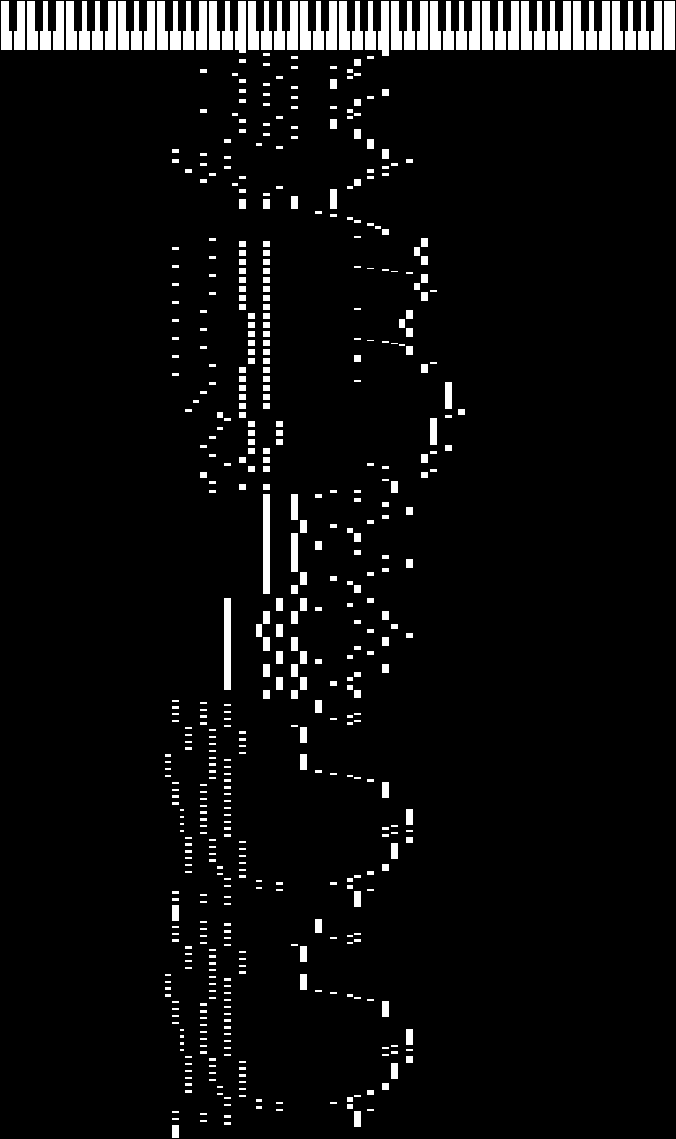

In [126]:
midi_to_image(y_test, ticks_per_beat, bpm, None, True, 0)

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers
        self.linear_layers = nn.ModuleList([
            nn.Linear(88, 128),  # 88 input features to 64 hidden units
            nn.Linear(128, 256),  # 64 hidden units to 32 hidden units
            nn.Linear(256, 256),  # 64 hidden units to 32 hidden units
            nn.Linear(256, 128),  # 64 hidden units to 32 hidden units
            nn.Linear(128, 88),   # 32 hidden units to 1 output (binary classification)
        ])

    def forward(self, x):
        x = torch.Tensor(x)
        for i, l in enumerate(self.linear_layers):
            if i < len(self.linear_layers)-1:
                x = F.relu(l(x))
            else:
                x = l(x)
        return x


tensor([38.0517])


Training: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s, accuracy=88, loss=0.00081, lr=0.0001]   


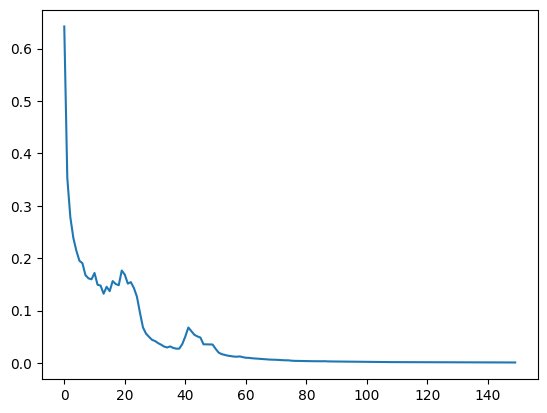

In [128]:
# Assuming you have input data X and target y as torch tensors
# X shape: (N_samples, 88)
# y shape: (N_samples, 1)

def train(X, y):

    X = torch.Tensor(X)
    y = torch.Tensor(y)

    num_epochs = 150
    batch_size = 128

    start_lr = 1e-2
    end_lr = 1e-4
    step_size = 25

    # Model, loss, optimizer, and learning rate scheduler
    model = Model()

    pos_weight = torch.tensor([y.size(0)*y.size(1)/torch.sum(y)])  # Weight for positive class (class 1)
    print(pos_weight)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = optim.Adam(model.parameters(), lr=start_lr)  # Adam optimizer

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=10**((np.log10(end_lr) - np.log10(start_lr))/num_epochs*step_size))  # Scheduler that halves LR every 10 epochs

    losses = []
    accuracies = []
    lrs = []

    # Training loop
    pbar = tqdm(range(num_epochs), total=num_epochs, desc="Training", dynamic_ncols=True)
    for epoch in pbar:
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        ind = torch.randperm(X.size(0))
        X = X[ind]
        y = y[ind]
        
        # Iterate over batches
        for i in range(0, len(X)-1, batch_size):
            inputs = X[i:i+batch_size, :]
            targets = y[i:i+batch_size, :]
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Remove extra dimension from the output (to match target shape)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Convert sigmoid output to binary (0 or 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        
        # Learning rate scheduler step
        scheduler.step()

        # Print statistics
        # print(running_loss,  (len(X) // batch_size))
        epoch_loss = running_loss / (len(X) // batch_size)
        # print(epoch_loss)
        accuracy = correct / total

        lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(loss=epoch_loss, accuracy=accuracy, lr=lr)

        
        losses.append(epoch_loss)
        accuracies.append(accuracy)
        lrs.append(lr)

    return model, losses, accuracies, lrs
# Optionally, you can save the model after training

model, losses, accuracies, lrs = train(X_train, y_train)

torch.save(model.state_dict(), "model2.pth")
plt.plot(losses)

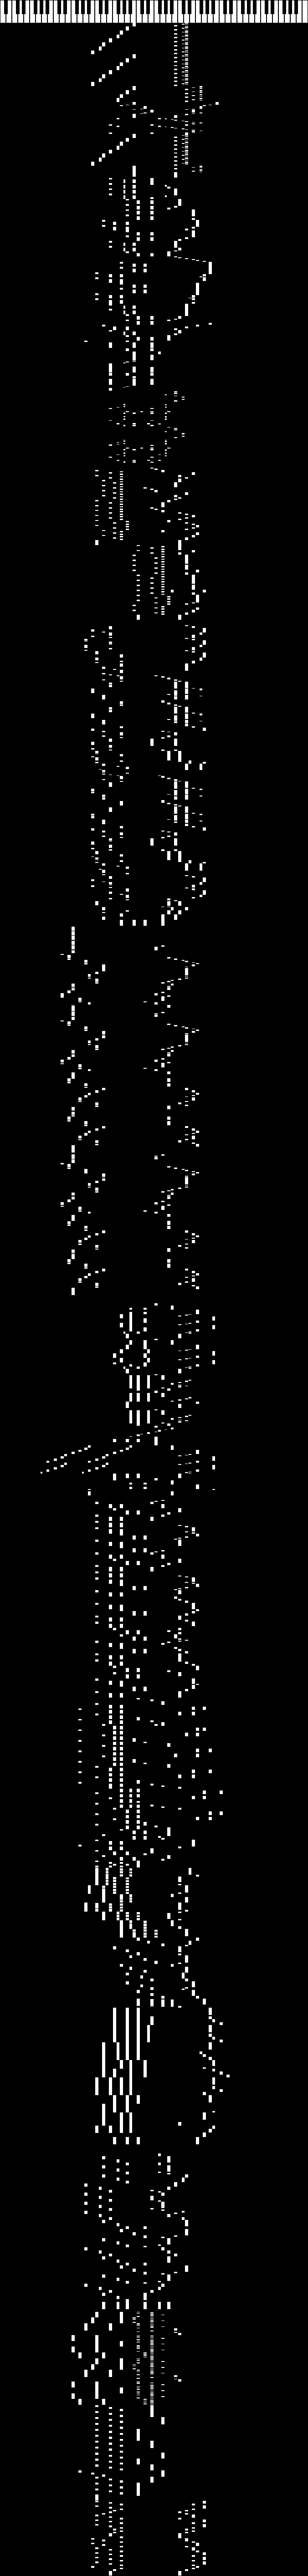

In [129]:
midi_to_image(y_train, ticks_per_beat, bpm, duration, True)

In [135]:
y_train.shape

(5607, 88)

(1089, 676) (1089, 676)


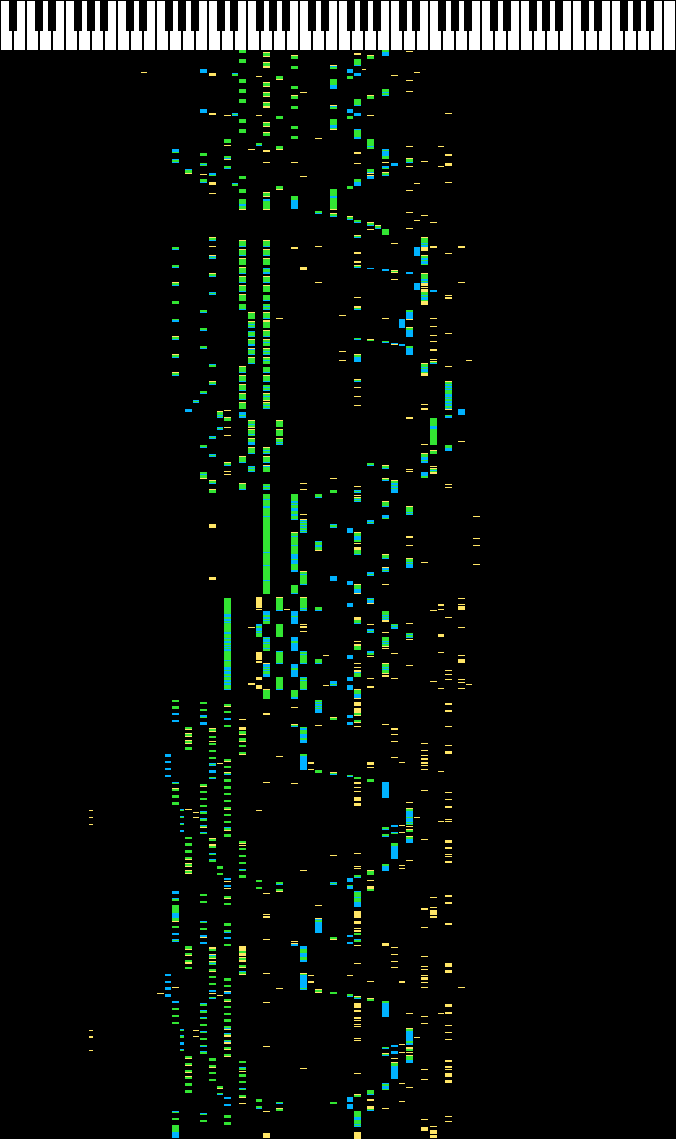

In [172]:
from display import midis_comparison
midis_comparison(
    y_test, model.forward(X_test).detach().numpy()>0.5,
    target_color=(0, 0.7, 1), preds_color=(1, 0.9, 0.4), correct_color=(0.2, 0.9, 0.2)
)